
## Contents
- Importing the required Libraries
- Reading and Cleaning the Data
- Preprocessing
- EDA - Generic and NLP related
- Embedding Models
  - Training from scratch- LSTM , BiLSTM , BiLSTM with Attention
  - Word2vec from scratch- LSTM
  - Naives Bayes Classifier
  - Pretrained Glove , word2vec and fastext using LSTM, BiLSTM, BiLSTM with attention layer and GRU
- BERT
- Report

## Importing the required Libraries

In [ ]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow==2.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import string
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
#NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#SKLEARN
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn import feature_selection, metrics, manifold, pipeline

import scikitplot as skplt


#KERAS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, LSTM, Bidirectional, Input, Layer, GRU
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.core import Activation, Dropout, Dense
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

#gensim
import gensim.models.word2vec as w2v
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

#Modeling
from transformers import BertTokenizer, TFBertModel, BertConfig,TFBertForSequenceClassification,AutoTokenizer
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
#downgrading for plotly
!pip install pyyaml==5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Reading and Cleaning the Data
Reference : https://www.kaggle.com/datasets/albenft/game-of-thrones-script-all-seasons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
got = pd.read_csv('/content/drive/MyDrive/Likitha/Game_of_Thrones_Script.csv')

__Cleaning the Data__

Few columns are in a different format. Changing the format of the data which will be useful for future use.
Season and Episode columns are changed to int columns for better analysis, Release data is converted to proper date and Name is cased accordingly.

In [ ]:
#Cleaning the data
got.Season = got.Season.str.replace("Season ",'')
got.Episode = got.Episode.str.replace("Episode ",'')

#Changing the case accordingly
got.Name = got.Name.str.title()

#converting the Dtypes
got['Release Date'] = pd.to_datetime(got['Release Date'])
got.Season=got.Season.astype(str).astype(int)
got.Episode=got.Episode.astype(str).astype(int)
got.dtypes

Release Date     datetime64[ns]
Season                    int64
Episode                   int64
Episode Title            object
Name                     object
Sentence                 object
dtype: object

## Preprocessing

__Data before preprocessing__

In [ ]:
#Data before preprocessing
got.head()

,Release Date,Season,Episode,Episode Title,Name,Sentence
0,2011-04-17,1,1,Winter is Coming,Waymar Royce,What do you expect? They're savages. One lot s...
1,2011-04-17,1,1,Winter is Coming,Will,I've never seen wildlings do a thing like this...
2,2011-04-17,1,1,Winter is Coming,Waymar Royce,How close did you get?
3,2011-04-17,1,1,Winter is Coming,Will,Close as any man would.
4,2011-04-17,1,1,Winter is Coming,Gared,We should head back to the wall.


**Defining a class for preprocessing**

Defined a custom class for preprocessing which includes 
- converting the case to lower
- removing puntuations along with few symbols which are not useful
- removing stop words from nltk
- creating tokens
- stemming the tokens
- lemmatizing the tokens

In [ ]:
class PreProcessing:
  def textprocessing(data, Sentence):
    data['lower'] = data.Sentence.apply(lambda x:x.lower())
    stop = nltk.corpus.stopwords.words('english')
    punc_stop= list(string.punctuation +','+'.') + stop
    data['after_ps'] = data.lower.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    data['tokens'] = data.after_ps.apply(lambda x: word_tokenize(x))
    stemmer = PorterStemmer().stem
    data['stemmed'] = data.tokens.apply(lambda x: [stemmer(word) for word in x])
    lemmatizer = WordNetLemmatizer().lemmatize
    data['lemmatized'] = data.tokens.apply(lambda x: [lemmatizer(word) for word in x]);

Applying the class to GOT dataframe and 'Sentence' column

In [ ]:
PreProcessing.textprocessing(got, 'Sentence')

In [ ]:
#Data after preprocessing
got.head()

,Release Date,Season,Episode,Episode Title,Name,Sentence,lower,after_ps,tokens,stemmed,lemmatized
0,2011-04-17,1,1,Winter is Coming,Waymar Royce,What do you expect? They're savages. One lot s...,what do you expect? they're savages. one lot s...,expect? they're savages. one lot steals goat a...,"[expect, ?, they, 're, savages, ., one, lot, s...","[expect, ?, they, 're, savag, ., one, lot, ste...","[expect, ?, they, 're, savage, ., one, lot, st..."
1,2011-04-17,1,1,Winter is Coming,Will,I've never seen wildlings do a thing like this...,i've never seen wildlings do a thing like this...,i've never seen wildlings thing like this. i'v...,"[i, 've, never, seen, wildlings, thing, like, ...","[i, 've, never, seen, wildl, thing, like, thi,...","[i, 've, never, seen, wildlings, thing, like, ..."
2,2011-04-17,1,1,Winter is Coming,Waymar Royce,How close did you get?,how close did you get?,close get?,"[close, get, ?]","[close, get, ?]","[close, get, ?]"
3,2011-04-17,1,1,Winter is Coming,Will,Close as any man would.,close as any man would.,close man would.,"[close, man, would, .]","[close, man, would, .]","[close, man, would, .]"
4,2011-04-17,1,1,Winter is Coming,Gared,We should head back to the wall.,we should head back to the wall.,head back wall.,"[head, back, wall, .]","[head, back, wall, .]","[head, back, wall, .]"


## Generic EDA

In [ ]:
#The important column -'Name' has null values 
got.loc[got.Name.isna()]

,Release Date,Season,Episode,Episode Title,Name,Sentence,lower,after_ps,tokens,stemmed,lemmatized
17387,2016-05-01,6,2,Home,NaN,"You leave the fighting to the little lords, Wy...","you leave the fighting to the little lords, wy...","leave fighting little lords, wylis come along,...","[leave, fighting, little, lords, ,, wylis, com...","[leav, fight, littl, lord, ,, wyli, come, alon...","[leave, fighting, little, lord, ,, wylis, come..."
17389,2016-05-01,6,2,Home,NaN,"Well, he's never going to learn to fight becau...","well, he's never going to learn to fight becau...","well, he's never going learn fight he's stable...","[well, ,, he, 's, never, going, learn, fight, ...","[well, ,, he, 's, never, go, learn, fight, he,...","[well, ,, he, 's, never, going, learn, fight, ..."
18619,2016-05-22,6,5,The Door,NaN,Wylis! What's the matter?,wylis! what's the matter?,wylis! what's matter?,"[wylis, !, what, 's, matter, ?]","[wyli, !, what, 's, matter, ?]","[wylis, !, what, 's, matter, ?]"


In [ ]:
#after looking at the dialogues, replacing Null values with a "Unknown"
got.Name.loc[got.loc[got.Name.isna()].index] = 'Unknown'

### Season and Episode Analysis

In [ ]:
#grouing the required data
season_episode_lines = got.groupby(['Season','Episode'], as_index=False)['Sentence'].count()
season_episode = season_episode_lines.groupby(['Season'], as_index=False)['Episode'].count()

#establishing longest and shortest episodes
season_episode_lines['SE'] = season_episode_lines[[
    'Season','Episode']].apply(lambda row: '_'.join([str(each) for each in row]),axis=1)
episode_len=season_episode_lines.sort_values(by = 'Sentence',ascending=False)
longest10Episodes=episode_len.head(10)
shortest10Episodes=episode_len.tail(10)

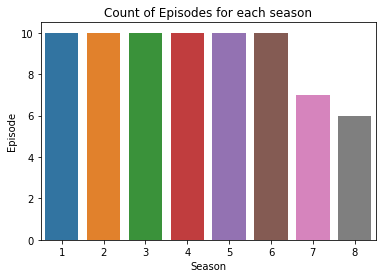

In [ ]:
#Episodes for each season
plt.xlabel("Season")
plt.ylabel("Count of Episodes")
plt.title("Count of Episodes for each season")
sns.barplot(season_episode.Season,season_episode.Episode)
plt.show()

__Season 1 to 6 have 10 Episodes each. S7 and S8 have lesser.__

As per the writers, directors and the producers, The whole series is supposed to have 7 Seasons with S7 to be the longest of all.
Because of increase in crazy fan base of the show,The makers decided to split it into two smaller seasons so as to build the suspense and accumulate required funds to shoot grand finale.

In [ ]:
#Longest Seasons
fig = px.pie(season_episode_lines, values='Sentence', names='Season'
             , title='Count of Lines for each Season')
fig.show()

#Episode wise split
fig = px.sunburst(season_episode_lines, path=['Season','Episode'], values='Sentence'
                   , title='Contribution of each episode to the entire Show')
fig.show()

__Longest Season among the 8 with respect to the count of dialogues is S2 with ~4000 dialogues.This could be for the following reasons__
- There was a major plot twist in Season1.Therefore S2 required a lot of explanation
- S2 also throws some light on the major elements of the show. i.e the dragons and Whitewalkers


__Shortest Season is S8 with ~1500 dialogues. Reasons for such a short season are:__
- Includes mostly the war scene with more visuals than dialogues
- The longest season has been decided to be split into S7 and S8


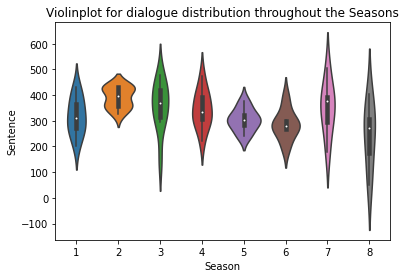

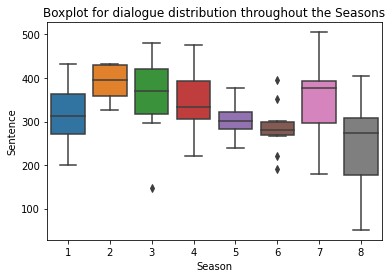

In [ ]:
plt.xlabel("Season")
plt.ylabel("Count of dialogues")
plt.title("Violinplot for dialogue distribution throughout the Seasons")
sns.violinplot(x="Season", y="Sentence", data=season_episode_lines)
plt.show()

plt.xlabel("Season")
plt.ylabel("Count of dialogues")
plt.title("Boxplot for dialogue distribution throughout the Seasons")
sns.boxplot(x="Season", y="Sentence", data=season_episode_lines)
plt.show()

__Dialogue length of episodes throughout the Season__

- S1, S4 and S5 have proportinate lenght of episode througout the season.
- The most disproportinate divison of episodes is for S6 followed by S3 , S8 and then S7. 
- These observation were based on the above shown outliers and gap between median and min/max value.

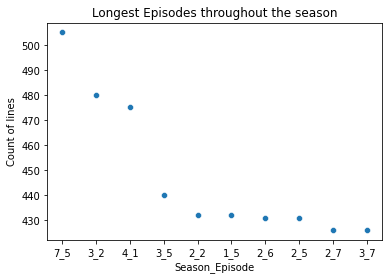

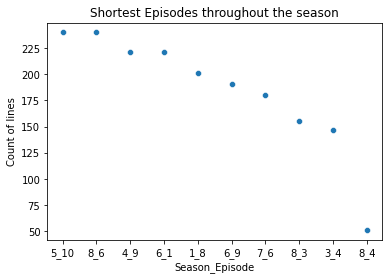

In [ ]:
plt.xlabel("Season_Episode")
plt.ylabel("Count of lines")
plt.title("Longest Episodes throughout the season")
sns.scatterplot(data=longest10Episodes, x="SE", y="Sentence")
plt.show()

plt.xlabel("Season_Episode")
plt.ylabel("Count of lines")
plt.title("Shortest Episodes throughout the season")
sns.scatterplot(data=shortest10Episodes, x="SE", y="Sentence")
plt.show()

The Longest Episodes of all time in GOT Series is Epidose 5 from Season 7 followed by S3 E2 and S4 E1.

The Shortest Episode is Episode 4 from Season 8.

### Further Analysis on Season 7 Episode 5


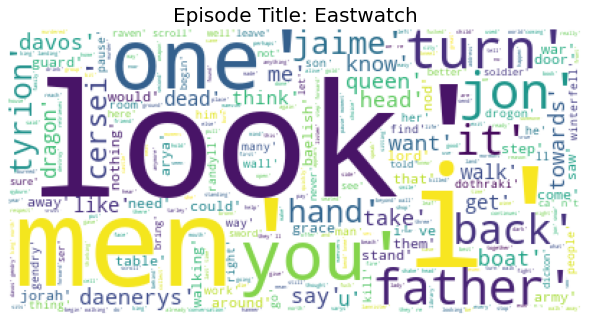

In [ ]:
S7= got[got['Season']==7]
S7_E5 = S7[S7['Episode']==5]
cloud = WordCloud(stopwords=STOPWORDS, max_words = 2000,background_color ='white').generate(' '.join(
    str(i) for i in S7_E5['lemmatized']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Episode Title: Eastwatch', fontsize=20)
plt.show() 

In [ ]:
S7_E5_character = S7_E5.Name.value_counts().\
reset_index().rename(columns={'Name':'Count','index':'Name'}).sort_values(by = 'Count',ascending=False)
S7_E5_character.head()

,Name,Count
0,Davos,57
1,Jon Snow,46
2,Tyrion Lannister,45
3,Daenerys Targaryen,44
4,Jaime Lannister,41


Season 7 Episode 5 is the Longest Episode and also highly viewed with 10.72 million views in its initial broadcast. The episode is treated to not only be cruical but also important as it has multiple dimensions.The episodes shows intense trys made by Davos and Jon Snow convinving Daenerys Targaryen and Tyrion Lannister about the "dead" i.e White Walkers .Therefore these four have the most dialogues compared to others.

### Character Screenspace Analysis

In [ ]:
#Season and character split
season_character = got.groupby(['Season','Name'], as_index=False)['Sentence'].count().sort_values(by = 'Sentence',ascending=False)

#Top 5 character basis their count of dialogues in different season
season_character_top5=season_character.sort_values(['Sentence'], 
                                                ascending=False).groupby('Season').head(5)

##Top 5 character basis their count of dialogues in all seasons together
character_dialogue=season_character.groupby(['Name'], as_index=False)['Sentence'].sum().sort_values(by = 'Sentence',ascending=False)
character_dialogue_top10=character_dialogue.head(10)

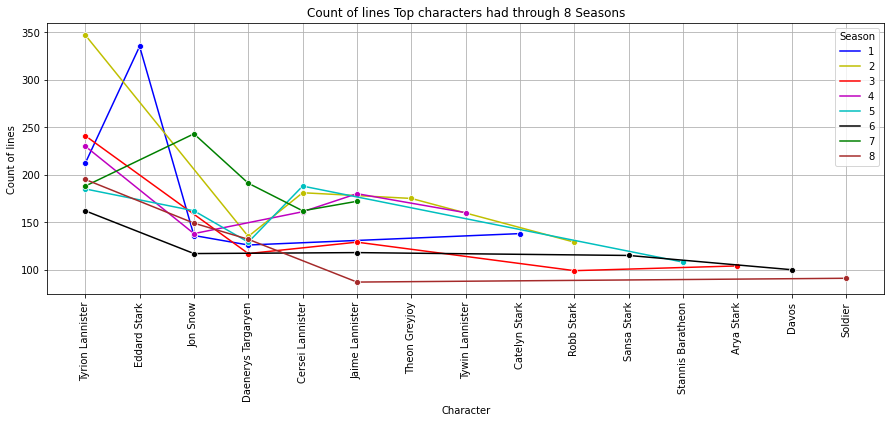

In [ ]:
px.bar(character_dialogue_top10, y='Sentence', x='Name', text='Sentence', 
       title="Characters with Highest Screenspace throughout all seasons", 
       labels={'x': 'Characters', 'y':'Count of lines'}).update_traces(textposition='outside').show()

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
plt.xlabel("Character")
plt.ylabel("Count of lines")
plt.title("Count of lines Top characters had through 8 Seasons")
sns.lineplot('Name', 'Sentence', hue='Season', palette=['b','y','r','m','c','k','g','brown'], data=season_character_top5, marker="o")
plt.grid()
plt.show()

From the above two plots the characters which took most of the screen time are
- Tyrion Lannister - He has been the most famous of the all.Throughout all the seasons , he had the most amount of lines.His graph has higher dialogues in the begining and slows down at the end as the last few season includes war whereas Tyrion is the least partipant
- Jon Snow
- Daenerys Targaryen
- Cersi Lannister
- Eddard Stark - Eddard Stark when considering the complete season is not in top 10 however if we look at the season wise split he has 2nd highest dialogues in Season1 . Reason being the character was dead in Season 1 climax and didnt appear in other seasons.

### WordCloud on Tyrion Lannister

In [ ]:
tl = got[got['Name']=='Tyrion Lannister']

common = ['theres','want', 'dont','would','im','like','say','youre','go','see']
tl['after_common'] = tl.lemmatized.apply(lambda x: " ".join(x for x in x if x not in common))

tl1 = tl[tl['Season']==1]

tl8 = tl[tl['Season']==8]

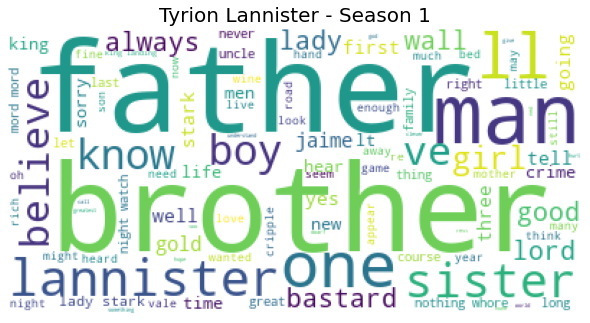

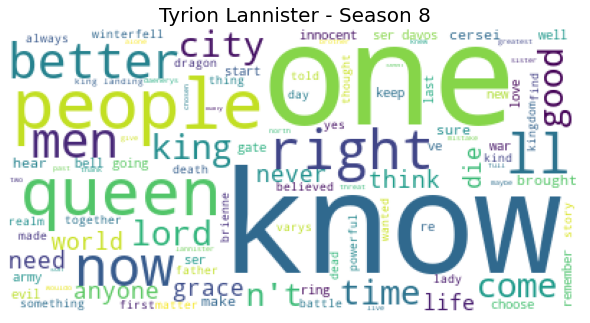

In [ ]:
cloud = WordCloud(stopwords=STOPWORDS, max_words = 100,background_color ='white').generate(' '.join(
    i for i in tl1['after_common']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Tyrion Lannister - Season 1', fontsize=20)
plt.show()

cloud = WordCloud(stopwords=STOPWORDS, max_words = 100,background_color ='white').generate(' '.join(
    i for i in tl8['after_common']))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Tyrion Lannister - Season 8', fontsize=20)
plt.show()

The most used word of __Tyrion Lannister__ from __S1__ to __S8__ has a drastic change.

Season 1:
- It is observed that he was very much devoted to his house __"Lannister"__ and his __"Family"__ which includes his __"Father"__ , __"Brother"__, __"Sister"__ and __"Mother"__ who is no more but he tries to refer her quite often. -- He was also seen to use __foul__ language quite often.

Season8:
- By this time he is already __"Hand of the Queen"__
- There are lot of reference related to the general __people__ ,__men__,__world__ and their welfare in his conversation
- He is not in favour of his so called family where in he refers to his sister with name i.e __"Cersei"__
- He is addressing people with more __respect__

In the whole Series __"Tyrion Lannister"__ is considered to be the character who __"Knows"__ a lot of things (know here is not a stopword) and his character shapes as a wise man


### Conclusion on EDA


### Seasons and Episodes Analysis
- __Season 1 to 6 have 10 Episodes each. S7 and S8 have lesser.__
As per the writers, directors and the producers, The whole series is supposed to have 7 Seasons with S7 to be the longest of all.
Because of increase in crazy fan base of the show,the makers decided to split it into two smaller seasons so as to build the suspense and accumulate required funds to shoot grand finale.
- __Longest Season among the 8 with respect to the count of dialogues is S2 with ~4000 dialogues.This could be for the following reasons__
 - There was a major plot twist in Season1.Therefore S2 required a lot of explanation
 - S2 also throws some light on the major elements of the show. i.e the dragons and Whitewalkers
- __Shortest Season is S8 with ~1500 dialogues. Reasons for such a short season are:__
 - Includes mostly the war scene with more visuals than dialogues
 - The longest season has been decided to be split into S7 and S8
- __Dialogue length of episodes throughout the Season__
 - S1, S4 and S5 have proportinate length of episode througout the season.
 - The most disproportinate divison of episodes is for S6 followed by S3 , S8 and then S7. 
 - These observation were based on the outliers and gap between median and min/max value from box and violinplot

### Analysis on Longest Episode
Season 7 Episode 5 is the Longest Episode and also highly viewed with 10.72 million views in its initial broadcast. The episode is treated to not only be cruical but also important as it has multiple dimensions.The episodes shows intense trys made by Davos and Jon Snow convinving Daenerys Targaryen and Tyrion Lannister about the "dead" i.e White Walkers 


## Character Screenspace Analysis
Characters with the most Screespance are :
- Tyrion Lannister - He has been the most famous of the all.Throughout all the seasons , he had the most amount of lines.His graph has higher dialogues in the begining and slows down at the end as the last few season includes war whereas Tyrion is the least partipant
- Jon Snow
- Daenerys Targaryen
- Cersi Lannister
- Eddard Stark - Eddard Stark when considering the complete season is not in top 10 however if we look at the season wise split he has 2nd highest dialogues in Season1 . Reason being the character was dead in Season 1 climax and didnt appear in other seasons.

### WorldCloud on Most spoken Character
The most used word of __Tyrion Lannister__ from __S1__ to __S8__ has a drastic change.

Season 1:
- It is observed that he was very much devoted to his house __"Lannister"__ and his __"Family"__ which includes his __"Father"__ , __"Brother"__, __"Sister"__ and __"Mother"__ who is no more but he tries to refer her quite often. -- He was also seen to use __foul__ language quite often.

Season8:
- By this time he is already __"Hand of the Queen"__
- There are lot of reference related to the general __people__ ,__men__,__world__ and their welfare in his conversation
- He is not in favour of his so called family where in he refers to his sister with name i.e __"Cersei"__
- He is addressing people with more __respect__

In the whole Series __"Tyrion Lannister"__ is considered to be the character who __"Knows"__ a lot of things (know here is not a stopword) and his character shapes as a wise man

## NLP Related EDA

Creating a dictionary:

Dictionary include all the word that have been used in the GOT dataset. The Frequency of each word is also identify which tell how many time a particular word is repeated.

In [ ]:
#Creating a dictionary
dictionary=got['lemmatized'].tolist()
print('The length of the dictionary is',len(dictionary))

subword_dictionary=[item for sublist in dictionary for item in sublist]
print('The length of the subword dictionary is',len(subword_dictionary))

The length of the dictionary is 23911
The length of the subword dictionary is 214413


Top 10 words and their frequency


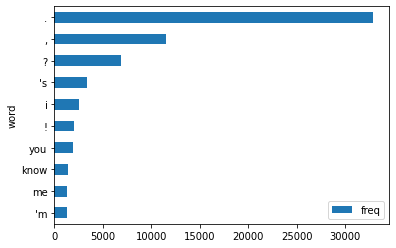

In [ ]:
#Word Frequency
word_counter = Counter(subword_dictionary)

#Plotting top 10 most repeated words
Top_10_common_words = word_counter.most_common()[:10]
Top_10_common_words = pd.DataFrame(Top_10_common_words)
Top_10_common_words.columns = ['word', 'freq']
print('Top 10 words and their frequency')
Top_10_common_words.sort_values(by='freq',ascending=True).plot(x='word', kind='barh')
plt.show()

The above plot shows the Top 10 words that have been repeated the most. All the above words are actually stop words

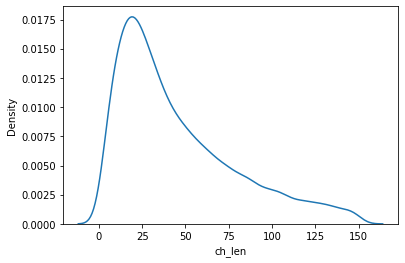

In [ ]:
got_eda=got
got_eda['ch_len']=got_eda['Sentence'].apply(lambda x:len(x))
got_eda=got_eda.loc[got_eda['ch_len']<=150]
got_ch_len = got_eda['ch_len']
sns.kdeplot(data=got_ch_len)
plt.show()

The Density of the lenght of dialogues most ranges from 25 words to 50 words per dialogue. There are fewer dialogues with words more than 100

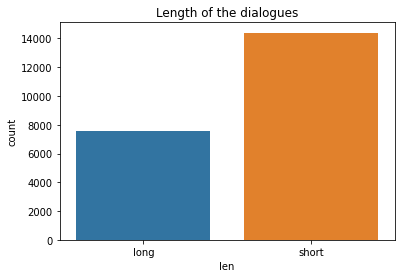

In [ ]:
got_eda['len']=got_eda['ch_len'].apply(lambda x:'short' if x <=50 else 'long')
sns.countplot(data=got_eda,x='len').set_title('Length of the dialogues');

Most of the dialogues in the script are short as shown in the above bar graph

## Sentiment Analysis

Sentiment analysis is a text analysis method that detects polarity within the text, whether a whole document, paragraph, sentence, or clause. The same is used to identify if the dialogue is positive or negative

In [ ]:
#Adding labels to the data using vaderSentiment
sentiment_model = SentimentIntensityAnalyzer()

got['n_score'] = [sentiment_model.polarity_scores(x)['neg'] for x in got['Sentence']]

got.loc[got['n_score'] > 0.1, 'Sentiments'] = 'neg'
got.loc[got['n_score'] <= 0.1, 'Sentiments'] = 'pos'

got.Sentiments.value_counts()

pos    17234
neg     6677
Name: Sentiments, dtype: int64

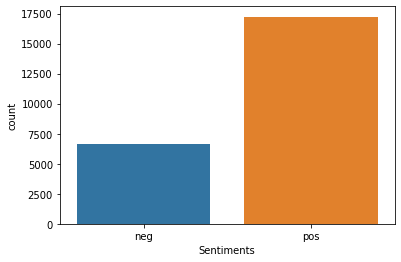

In [ ]:
sns.countplot(x='Sentiments', data=got)

The above plot shows the bargraph of the count of diagloues which are categorized as positive and negative basis SentimentIntensityAnalyzer.


### Splitting Train and Test data

A train column is created basis lemmatized column which is joined. X and Y nodes are assigned which denoted lemmatized train data and Sentiments

In [ ]:
got['lemmatized_train'] = got.lemmatized.apply(lambda x: ' '.join(x))

x = (got['lemmatized_train'])
y = (got['Sentiments'])

#Label Encoding Target Variable:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [ ]:
list(le.classes_)

['neg', 'pos']

In [ ]:
y = le.transform(y)
print('Labels for \'{}\' are \'{}\' respectively.'.format(le.inverse_transform(np.unique(y)),np.unique(y)))

Labels for '['neg' 'pos']' are '[0 1]' respectively.


**Building bag of Words using CountVectorizer**

Converting a collection of text documents to a matrix of token counts using count vectorizer.Below we can see the unique words in a dictionary along with its frequency.



In [ ]:
bow = CountVectorizer(max_features=25000, lowercase=True,analyzer = "word")
train_bow_neg = bow.fit_transform(x)
train_bow_neg
print('Size of neg bag of words',train_bow_neg.toarray().shape)
train_bow_neg.toarray()[1:5]

Size of neg bag of words (23911, 8272)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vocab = bow.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(train_bow_neg.toarray(), axis=0)

wfh = pd.DataFrame({'word':vocab,'freq':dist})
wfh.sort_values(by='freq',ascending=False)[:10]

,word,freq
8257,you,1952
3914,know,1362
4383,me,1357
4174,lord,1212
4890,one,1190
3876,king,1174
3747,it,1084
7929,want,1017
4113,ll,999
7296,that,955


## Embedding Models

### Tokenizing and Padding

Tokenizing helps to break the words into tokens.
Padding adds a special padding token to ensure shorter sequences will have the same length to maintain uniformity.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
maxlen=100
#using keras tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


In [ ]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7748

### Defining Customer Functions

Instead of calling the whole thing again and again , created few custom functions that can be called anytime.

__Class for BiLSTM with Attention Layer__

A Class is created defining the attention layer that is further used in BiLSTM model under different circumstances

In [ ]:
class attention(Layer):
    def __init__(self, return_sequences=True):
      self.return_sequences = return_sequences
      super(attention,self).__init__()

    def build(self, input_shape):
      self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                             initializer="normal")
      self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                             initializer="normal")
      
    def call(self, x):
      e = K.tanh(K.dot(x,self.W)+self.b)
      a = K.softmax(e, axis=1)
      output = x*a
      if self.return_sequences:
        
        return output
        
      return K.sum(output, axis=1)

__Defining Performance Plot__

Performance Plot includes model accuracy and model loss trend over the epoches ran for each model.

In [ ]:
def show_performance_plot(history):
  #show the model accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

__Defining colors__

In [ ]:
#Defining class for color
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Training the model from scratch

With the help of any pretrained model or data , we are here trying to run the model from scratch

#### LSTM without any Pretrained Data

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
TrainmodelLSTM = Sequential()
TrainmodelLSTM.add(embedding_layer)
TrainmodelLSTM.add(LSTM(128, return_sequences=True))
TrainmodelLSTM.add(Flatten())
TrainmodelLSTM.add(Dropout(0.5))
TrainmodelLSTM.add(Dense(1, activation='sigmoid'))


TrainmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(TrainmodelLSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          774800    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 1)                 12801     
                                                                 
Total params: 904,849
Trainable params: 904,849
Non-trainable params: 0
_________________________________________________________________
None


Model Training and Evaluation

In [ ]:
historyTrainmodelLSTM = TrainmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelLSTM= TrainmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
117/120 [============================>.] - ETA: 0s - loss: 0.4961 - acc: 0.7652WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0e0652290> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.855948149696843
150/150 [==============================] - 1s 4ms/step - loss: 0.6833 - acc: 0.8559
[0.6832773089408875, 0.8559481501579285]
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1325
           1       0.88      0.93      0.90      3458

    accuracy                           0.86      4783
   ma

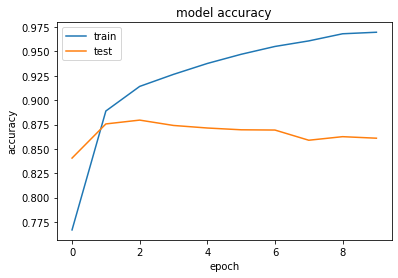

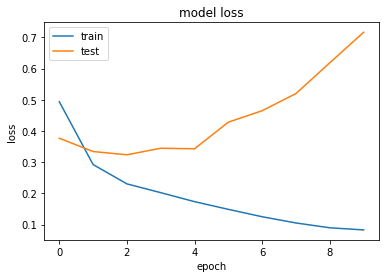

In [ ]:
y_pred = (TrainmodelLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelLSTM)

####BiLSTM without any Pretrained Data

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
TrainmodelBiLSTM = Sequential()
TrainmodelBiLSTM.add(embedding_layer)
TrainmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
TrainmodelBiLSTM.add(Flatten())
TrainmodelBiLSTM.add(Dropout(0.5))
TrainmodelBiLSTM.add(Dense(1, activation='sigmoid'))


TrainmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(TrainmodelBiLSTM.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          774800    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25600)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 1,034,897
Trainable params: 1,034,897
Non-trainable params: 0
____________________________________________

In [ ]:
historyTrainmodelBiLSTM = TrainmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelBiLSTM= TrainmodelBiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.4998 - acc: 0.7589WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0bda0f3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8477942713777964
150/150 [==============================] - 1s 7ms/step - loss: 0.6243 - acc: 0.8478
[0.6242513656616211, 0.8477942943572998]
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1325
           1       0.88      0.91      0.90      3458

    accuracy                           0.85      4783
   m

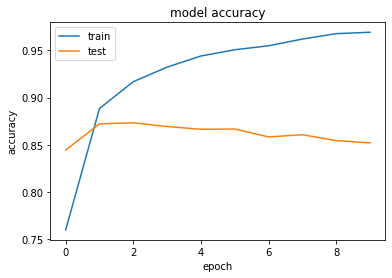

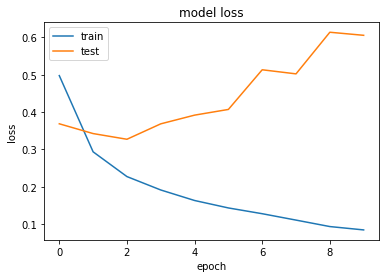

In [ ]:
y_pred = (TrainmodelBiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelBiLSTM)

####BiLSTM with attention layer without any Pretrained Data

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
TrainmodelABiLSTM = Sequential()
TrainmodelABiLSTM.add(embedding_layer)
TrainmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
TrainmodelABiLSTM.add(attention(return_sequences=True))
TrainmodelABiLSTM.add(Flatten())
TrainmodelABiLSTM.add(Dropout(0.5))
TrainmodelABiLSTM.add(Dense(1, activation='sigmoid'))


TrainmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(TrainmodelABiLSTM.summary())


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          774800    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         234496    
 nal)                     

Running the model

In [ ]:
historyTrainmodelABiLSTM = TrainmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelABiLSTMM= TrainmodelABiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.5501 - acc: 0.7182WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0bcba67a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8670290612586243
150/150 [==============================] - 1s 7ms/step - loss: 0.4030 - acc: 0.8670
[0.40297895669937134, 0.867029070854187]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1325
           1       0.91      0.91      0.91      3458

    accuracy                           0.87      4783
   m

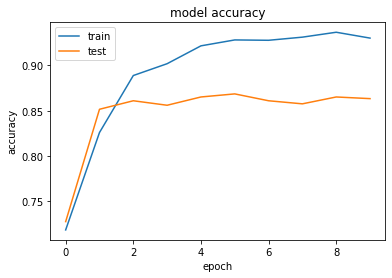

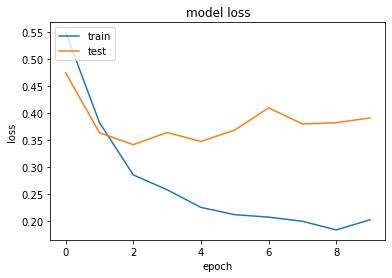

In [ ]:
y_pred = (TrainmodelABiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelABiLSTM)

####Word2Vec from Scratch

As per the above LSTM accuracy is better than Bi LSTM with and without attention layer . Therefore further model evaluation is done using LSTM

In [ ]:
## train Word2Vec from scratch
#Train Word2Vec model with gensim on the dataset
w2v_model = w2v.Word2Vec(got.lemmatized, window=10, min_count=2, workers=5, sample = 0.001)

In [ ]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
w2v_vocab_size, w2v_embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(w2v_vocab_size, w2v_embedding_size))

Vocabulary Size: 5296 - Embedding Dim: 100


Training and Running the Model

In [ ]:
#Training the model with trained word2vec weights
w2vembedding_layer = Embedding(vocab_size, 100, weights=[w2v_weights], input_length=maxlen , trainable=False)
w2vmodelLSTM = Sequential()
w2vmodelLSTM.add(embedding_layer)
w2vmodelLSTM.add(LSTM(128, return_sequences=True))
w2vmodelLSTM.add(Flatten())
w2vmodelLSTM.add(Dropout(0.5))
w2vmodelLSTM.add(Dense(1, activation='sigmoid'))


w2vmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(w2vmodelLSTM.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          774800    
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          117248    
                                                                 
 flatten_3 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 904,849
Trainable params: 904,849
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Running the model
historyw2vmodelLSTM = w2vmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestw2vmodelLSTM= w2vmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
120/120 [==============================] - ETA: 0s - loss: 0.3023 - acc: 0.8761WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0e0044560> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8498850094083211
150/150 [==============================] - 1s 4ms/step - loss: 0.7182 - acc: 0.8499
[0.7182084321975708, 0.8498849868774414]
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1325
           1       0.87      0.93      0.90      3458

    accuracy                           0.85      4783
   m

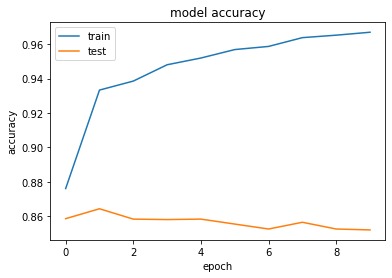

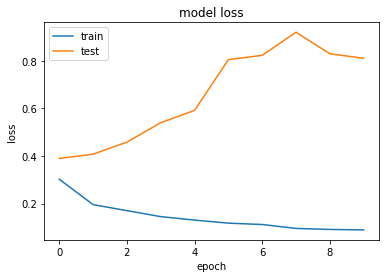

In [ ]:
y_pred = (w2vmodelLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(w2vmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyw2vmodelLSTM)

###Pre-Trained Models

#### Naives Bayes Classifier

In [ ]:
#Splitting the data into test and train 
xtrain, xtest, ytrain, ytest = train_test_split \
                (train_bow_neg.toarray(), y,test_size=0.3, \
                random_state=1000)

In [ ]:
print ("No. of True Cases in training data set for" , ytrain.sum())
print ("No. of True Cases in testing data set for",ytest.sum())

print ("Ratio of True Cases in training data set: " , round(ytrain.sum()/len(ytrain),2))
print ("Ratio of True Cases in testing data set: ", round(ytest.sum()/len(ytest),2))

No. of True Cases in training data set for 12061
No. of True Cases in testing data set for 5173
Ratio of True Cases in training data set:  0.72
Ratio of True Cases in testing data set:  0.72


In [ ]:
xtrain.shape

(16737, 8272)

In [ ]:
train_bow_neg

<23911x8272 sparse matrix of type '<class 'numpy.int64'>'
	with 141879 stored elements in Compressed Sparse Row format>

In [ ]:
NB = MultinomialNB()
NB_clf = NB.fit( xtrain, ytrain )

In [ ]:
prob_test  = NB.predict_proba(xtest)
prob_train = NB.predict_proba(xtrain)

#Probability Threshold = 0.5 (default) 
pred_test  = NB.predict(xtest)
pred_train = NB.predict(xtrain)

Model ROC-AUC score for training sample: 0.930
Model ROC-AUC score for test sample: 0.845
Train Accuracy ::  0.9052996355380295
Test Accuracy ::  0.8490381934764427

 Confusion matrix: 



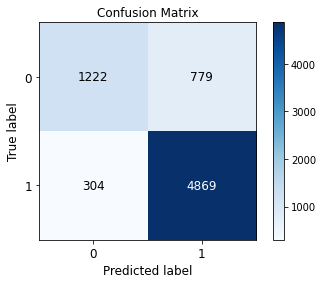

              precision    recall  f1-score   support

           0       0.61      0.80      0.69      1526
           1       0.94      0.86      0.90      5648

    accuracy                           0.85      7174
   macro avg       0.78      0.83      0.80      7174
weighted avg       0.87      0.85      0.86      7174



In [ ]:
#Performance Evaluation of Naives Bayes Classifier
auc_score = roc_auc_score(ytrain, prob_train[:,1])
print ("Model ROC-AUC score for training sample: %.3f" \
                                      % auc_score)
auc_score = roc_auc_score(ytest, prob_test[:,1])
print ("Model ROC-AUC score for test sample: %.3f" \
                                      % auc_score)

#Calculate train and test accuracy
train_acc = accuracy_score(ytrain, pred_train)
test_acc  = accuracy_score(ytest, pred_test)
print ("Train Accuracy :: ", train_acc)
print ("Test Accuracy :: ", test_acc)

#Confusion Matrix
print ("\n Confusion matrix: \n")
skplt.metrics.plot_confusion_matrix(ytest, pred_test, title="Confusion Matrix",
                text_fontsize='large')
plt.show()

#Classification_report
print(classification_report(pred_test,ytest))

####Pretrained Glove Model

In [ ]:
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(7748, 100)


In [ ]:
print('Shape of train sequences: ',x_train.shape)
print('Shape of train labels: ',y_train.shape)
print("Shape of Validation sequences: ",x_test.shape)
print("Shape of Validation  labels: ",y_test.shape)

Shape of train sequences:  (19128, 100)
Shape of train labels:  (19128, 1)
Shape of Validation sequences:  (4783, 100)
Shape of Validation  labels:  (4783, 1)


#####Pretrained Glove LSTM

In [ ]:
gembedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
PretrainedmodelLSTM = Sequential()
PretrainedmodelLSTM.add(gembedding_layer)
PretrainedmodelLSTM.add(LSTM(128, return_sequences=True))
PretrainedmodelLSTM.add(Flatten())
PretrainedmodelLSTM.add(Dropout(0.5))
PretrainedmodelLSTM.add(Dense(1, activation='sigmoid'))


PretrainedmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PretrainedmodelLSTM.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          774800    
                                                                 
 lstm_4 (LSTM)               (None, 100, 128)          117248    
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 904,849
Trainable params: 130,049
Non-trainable params: 774,800
_________________________________________________________________
None


In [ ]:
historyPretrainedmodelLSTM = PretrainedmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrainedmodelLSTM= PretrainedmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
116/120 [============================>.] - ETA: 0s - loss: 0.4736 - acc: 0.7865WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0796da4d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8553209282876856
150/150 [==============================] - 1s 5ms/step - loss: 0.3740 - acc: 0.8553
[0.37395069003105164, 0.855320930480957]
              precision    recall  f1-score   support

           0       0.87      0.56      0.68      1325
           1       0.85      0.97      0.91      3458

    accuracy                           0.86      4783
   m

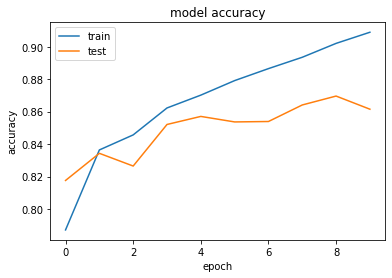

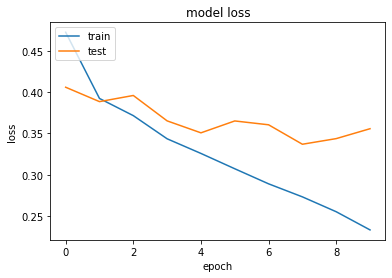

In [ ]:
y_pred = (PretrainedmodelLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PretrainedmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrainedmodelLSTM)

#####Predefined Glove BiLSTM

In [ ]:
gembedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
PretrainedmodelBiLSTM = Sequential()
PretrainedmodelBiLSTM.add(gembedding_layer)
PretrainedmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
PretrainedmodelBiLSTM.add(Flatten())
PretrainedmodelBiLSTM.add(Dropout(0.5))
PretrainedmodelBiLSTM.add(Dense(1, activation='sigmoid'))


PretrainedmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PretrainedmodelBiLSTM.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          774800    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_5 (Dropout)         (None, 25600)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 1,034,897
Trainable params: 260,097
Non-trainable params: 774,800
________________________________________

In [ ]:
historyPretrainedmodelBiLSTM = PretrainedmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrainedmodelBiLSTM= PretrainedmodelBiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.4798 - acc: 0.7812WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc07813c8c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8653564708342045
150/150 [==============================] - 1s 7ms/step - loss: 0.3857 - acc: 0.8654
[0.3856986165046692, 0.8653564453125]
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      1325
           1       0.88      0.94      0.91      3458

    accuracy                           0.87      4783
   macr

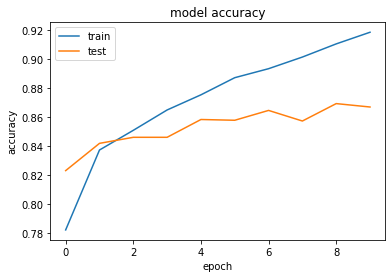

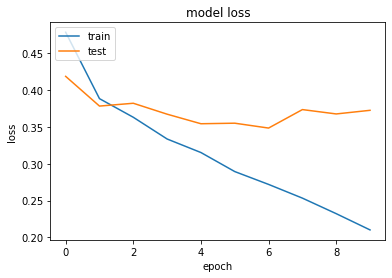

In [ ]:
y_pred = (PretrainedmodelBiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PretrainedmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrainedmodelBiLSTM)

#####Pretrained GloveDefining BiLSTM with Attention Layer

In [ ]:
gembedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
PretrainedmodelABiLSTM = Sequential()
PretrainedmodelABiLSTM.add(gembedding_layer)
PretrainedmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
PretrainedmodelABiLSTM.add(attention(return_sequences=True))
PretrainedmodelABiLSTM.add(Flatten())
PretrainedmodelABiLSTM.add(Dropout(0.5))
PretrainedmodelABiLSTM.add(Dense(1, activation='sigmoid'))


PretrainedmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PretrainedmodelABiLSTM.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          774800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_6 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25600)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25601     
                                                      

Running the model

In [ ]:
historyPreTrainedmodelABiLSTM = PretrainedmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPreTrainedmodelABiLSTM= PretrainedmodelABiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.5895 - acc: 0.7152WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0c02f2830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8532301902571607
150/150 [==============================] - 1s 7ms/step - loss: 0.3619 - acc: 0.8532
[0.3619093596935272, 0.8532301783561707]
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      1325
           1       0.88      0.92      0.90      3458

    accuracy                           0.85      4783
   m

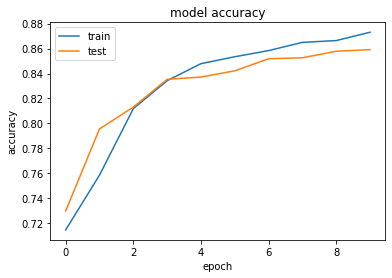

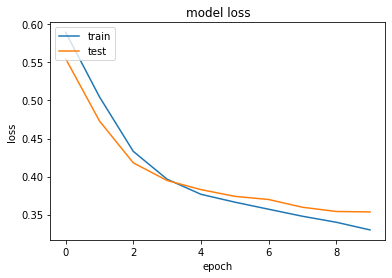

In [ ]:
y_pred = (PretrainedmodelABiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PretrainedmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPreTrainedmodelABiLSTM)

#####Pretrain Glove GRU

In [ ]:
emb_dim = embedding_matrix.shape[1]
Pretrained_gru_model = Sequential()
Pretrained_gru_model.add(Embedding(vocab_size, emb_dim, trainable = False, weights=[embedding_matrix]))
Pretrained_gru_model.add(GRU(128, return_sequences=False))
Pretrained_gru_model.add(Dropout(0.5))
Pretrained_gru_model.add(Dense(1, activation = 'sigmoid'))
Pretrained_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(Pretrained_gru_model.summary())



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         774800    
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 863,249
Trainable params: 88,449
Non-trainable params: 774,800
_________________________________________________________________
None


In [ ]:
history_Pretrained_gru_model = Pretrained_gru_model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTest_Pretrained_gru_model= Pretrained_gru_model.evaluate(x_test, y_test, verbose=1)



Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/120 [============================>.] - ETA: 0s - loss: 0.6040 - acc: 0.7154WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc07cac9b90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.7229772109554673
150/150 [==============================] - 1s 4ms/step - loss: 0.5903 - acc: 0.7230
[0.5902754068374634, 0.7229772210121155]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.72      1.00      0.84      3458

    accuracy                           0.72      4783
   m

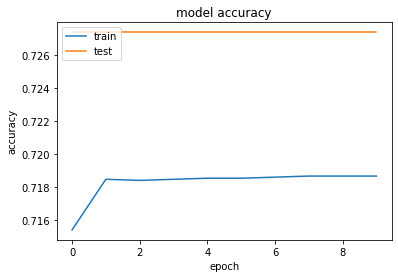

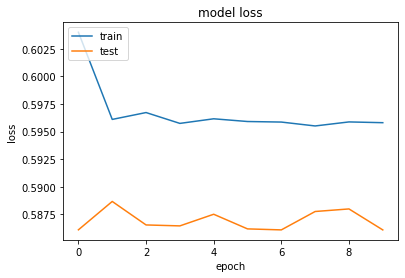

In [ ]:
y_pred = (Pretrained_gru_model.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrained_gru_model.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(history_Pretrained_gru_model)

####Pretrained Word2Vec

pretrained data from : https://www.kaggle.com/datasets/pkugoodspeed/nlpword2vecembeddingspretrained

In [ ]:
pretrain_w2v = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'
pretrain_w2v_model = KeyedVectors.load_word2vec_format(pretrain_w2v, binary=True)

In [ ]:
pretrain_w2v_embedding_matrix = np.zeros((vocab_size,300))
for word,index in tokenizer.word_index.items():
    try:
        embedding_value = pretrain_w2v_model[word]
        if embedding_value is not None:
            pretrain_w2v_embedding_matrix[index] = embedding_value         
    except KeyError:
        pretrain_w2v_embedding_matrix[index]=np.random.normal(0,np.sqrt(0.25),300)  

#####LSTM pretrain word2vec

In [ ]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[pretrain_w2v_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_w2vmodelLSTM = Sequential()
Pretrain_w2vmodelLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelLSTM.add(LSTM(128, return_sequences=True))
Pretrain_w2vmodelLSTM.add(Flatten())
Pretrain_w2vmodelLSTM.add(Dropout(0.5))
Pretrain_w2vmodelLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelLSTM.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 300)          2324400   
                                                                 
 lstm_10 (LSTM)              (None, 100, 128)          219648    
                                                                 
 flatten_10 (Flatten)        (None, 12800)             0         
                                                                 
 dropout_50 (Dropout)        (None, 12800)             0         
                                                                 
 dense_15 (Dense)            (None, 1)                 12801     
                                                                 
Total params: 2,556,849
Trainable params: 232,449
Non-trainable params: 2,324,400
_________________________________________________________________
None


In [ ]:
historyPretrain_w2vmodelLSTM = Pretrain_w2vmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelLSTM= Pretrain_w2vmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/120 [============================>.] - ETA: 0s - loss: 0.4608 - acc: 0.7910WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbd01ca24d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8613840685762074
150/150 [==============================] - 1s 5ms/step - loss: 0.3861 - acc: 0.8614
[0.3860608637332916, 0.8613840937614441]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1325
           1       0.88      0.93      0.91      3458

    accuracy                           0.86      4783
   m

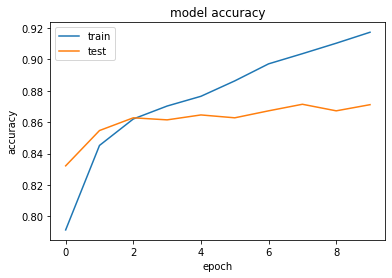

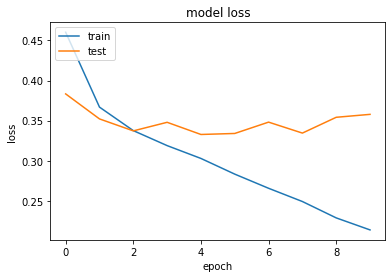

In [ ]:
y_pred = (Pretrain_w2vmodelLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelLSTM)

#####bilstm with pretrained word2vec

In [ ]:
Pretrain_w2vmodelBiLSTM = Sequential()
Pretrain_w2vmodelBiLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_w2vmodelBiLSTM.add(Flatten())
Pretrain_w2vmodelBiLSTM.add(Dropout(0.5))
Pretrain_w2vmodelBiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelBiLSTM.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 300)          2324400   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 25600)             0         
                                                                 
 dropout_51 (Dropout)        (None, 25600)             0         
                                                                 
 dense_16 (Dense)            (None, 1)                 25601     
                                                                 
Total params: 2,789,297
Trainable params: 464,897
Non-trainable params: 2,324,400
_____________________________________

In [ ]:
historyPretrain_w2vmodelBiLSTM = Pretrain_w2vmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelBiLSTM= Pretrain_w2vmodelBiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.4540 - acc: 0.7981WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbd0024c830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8477942713777964
150/150 [==============================] - 1s 7ms/step - loss: 0.4259 - acc: 0.8478
[0.42590761184692383, 0.8477942943572998]
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1325
           1       0.88      0.92      0.90      3458

    accuracy                           0.85      4783
   

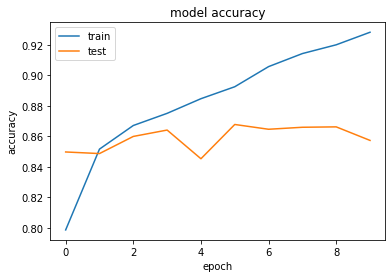

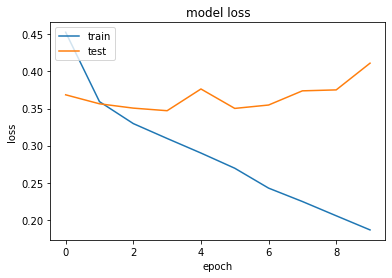

In [ ]:
y_pred = (Pretrain_w2vmodelBiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelBiLSTM)

#####Pretrained word2vec bilstm with attention layer

In [ ]:
Pretrain_w2vmodelABiLSTM = Sequential()
Pretrain_w2vmodelABiLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_w2vmodelABiLSTM.add(attention(return_sequences=True))
Pretrain_w2vmodelABiLSTM.add(Flatten())
Pretrain_w2vmodelABiLSTM.add(Dropout(0.5))
Pretrain_w2vmodelABiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelABiLSTM.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 300)          2324400   
                                                                 
 bidirectional_7 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention_3 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_12 (Flatten)        (None, 25600)             0         
                                                                 
 dropout_52 (Dropout)        (None, 25600)             0         
                                                                 
 dense_17 (Dense)            (None, 1)                 25601     
                                                     

In [ ]:
historyPretrain_w2vmodelABiLSTM = Pretrain_w2vmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelABiLSTM= Pretrain_w2vmodelABiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.5634 - acc: 0.7131WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbcffa957a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8607568471670499
150/150 [==============================] - 1s 7ms/step - loss: 0.3526 - acc: 0.8608
[0.35262569785118103, 0.8607568740844727]
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1325
           1       0.87      0.94      0.91      3458

    accuracy                           0.86      4783
   

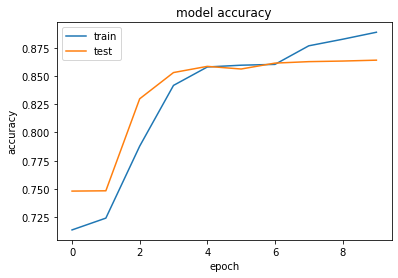

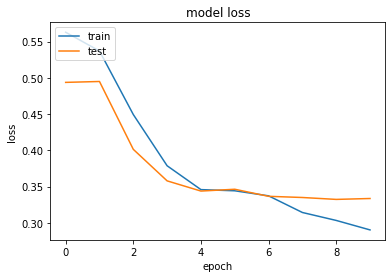

In [ ]:
y_pred = (Pretrain_w2vmodelABiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelABiLSTM)

#####Pretrain word2vec GRU model

In [ ]:
w2v_emb_dim = pretrain_w2v_embedding_matrix.shape[1]
Pretrain_w2v_gru_model = Sequential()
Pretrain_w2v_gru_model.add(Embedding(vocab_size, w2v_emb_dim, trainable = False, weights=[pretrain_w2v_embedding_matrix]))
Pretrain_w2v_gru_model.add(GRU(128, return_sequences=False))
Pretrain_w2v_gru_model.add(Dropout(0.5))
Pretrain_w2v_gru_model.add(Dense(1, activation = 'sigmoid'))
Pretrain_w2v_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(Pretrain_w2v_gru_model.summary())


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 300)         2324400   
                                                                 
 gru_2 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_53 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,489,649
Trainable params: 165,249
Non-trainable params: 2,324,400
_________________________________________________________________
None


In [ ]:
history_Pretrained_w2v_gru_model = Pretrain_w2v_gru_model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTest_Pretrained_w2v_gru_model= Pretrain_w2v_gru_model.evaluate(x_test, y_test, verbose=1)




Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/120 [============================>.] - ETA: 0s - loss: 0.6036 - acc: 0.7143WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbcfb612e60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.7229772109554673
150/150 [==============================] - 1s 4ms/step - loss: 0.5906 - acc: 0.7230
[0.590634286403656, 0.7229772210121155]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.72      1.00      0.84      3458

    accuracy                           0.72      4783
   ma

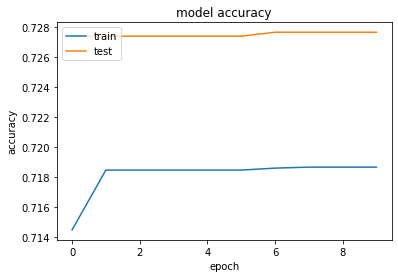

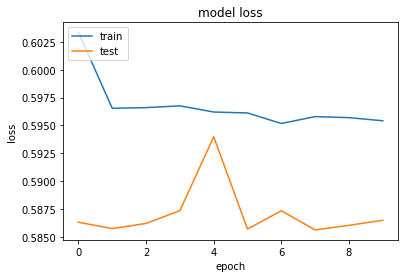

In [ ]:
y_pred = (Pretrain_w2v_gru_model.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2v_gru_model.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(history_Pretrained_w2v_gru_model)

#### Pretrained Fasttext

In [ ]:
pretrain_ft = '/content/drive/MyDrive/wiki-news-300d-1M.vec'

In [ ]:
def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
ft_embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(pretrain_ft) if len(o)>100)

In [ ]:
ft_embs = np.stack(ft_embeddings_index.values())
emb_mean,emb_std = ft_embs.mean(), ft_embs.std()
ft_embed_size = ft_embs.shape[1]

In [ ]:
ft_embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, ft_embed_size))
for word, index in tokenizer.word_index.items():
    ft_embedding_vector = ft_embeddings_index.get(word)
    if ft_embedding_vector is not None: 
      ft_embedding_matrix[index] = ft_embedding_vector
 

#####Pretrained ft LSTM

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_ftmodelLSTM = Sequential()
Pretrain_ftmodelLSTM.add(ft_embedding_layer)
Pretrain_ftmodelLSTM.add(LSTM(128, return_sequences=True))
Pretrain_ftmodelLSTM.add(Flatten())
Pretrain_ftmodelLSTM.add(Dropout(0.5))
Pretrain_ftmodelLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelLSTM.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 300)          2324400   
                                                                 
 lstm_7 (LSTM)               (None, 100, 128)          219648    
                                                                 
 flatten_7 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_8 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 2,556,849
Trainable params: 232,449
Non-trainable params: 2,324,400
_________________________________________________________________
None


In [ ]:
historyPretrain_ftmodelLSTM = Pretrain_ftmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelLSTM= Pretrain_ftmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/120 [============================>.] - ETA: 0s - loss: 0.5055 - acc: 0.7595WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0670dfdd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8682835040769391
150/150 [==============================] - 1s 5ms/step - loss: 0.3491 - acc: 0.8683
[0.3491249680519104, 0.8682835102081299]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1325
           1       0.90      0.92      0.91      3458

    accuracy                           0.87      4783
   m

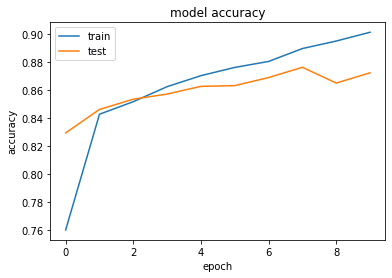

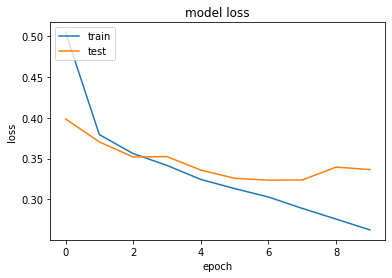

In [ ]:
y_pred = (Pretrain_ftmodelLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelLSTM)

#####Pretrain ft Bilstm

In [ ]:
Pretrain_ftmodelBiLSTM = Sequential()
Pretrain_ftmodelBiLSTM.add(ft_embedding_layer)
Pretrain_ftmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_ftmodelBiLSTM.add(Flatten())
Pretrain_ftmodelBiLSTM.add(Dropout(0.5))
Pretrain_ftmodelBiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelBiLSTM.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 300)          2324400   
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_9 (Dropout)         (None, 25600)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 2,789,297
Trainable params: 464,897
Non-trainable params: 2,324,400
_____________________________________

In [ ]:
historyPretrain_ftmodelBiLSTM = Pretrain_ftmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelBiLSTM= Pretrain_ftmodelBiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.5097 - acc: 0.7534WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc06588a200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.864729249425047
150/150 [==============================] - 1s 7ms/step - loss: 0.3410 - acc: 0.8647
[0.3409895598888397, 0.8647292256355286]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1325
           1       0.90      0.92      0.91      3458

    accuracy                           0.86      4783
   ma

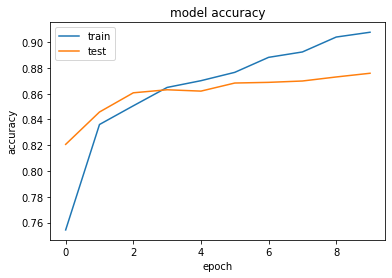

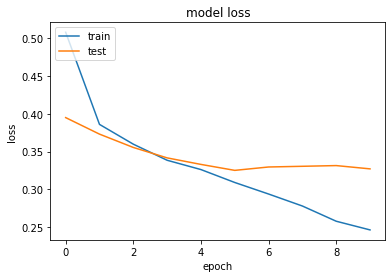

In [ ]:
y_pred = (Pretrain_ftmodelBiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelBiLSTM)

#####Bilstm pretrain ft with attention layer

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_ftmodelABiLSTM = Sequential()
Pretrain_ftmodelABiLSTM.add(ft_embedding_layer)
Pretrain_ftmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_ftmodelABiLSTM.add(attention(return_sequences=True))
Pretrain_ftmodelABiLSTM.add(Flatten())
Pretrain_ftmodelABiLSTM.add(Dropout(0.5))
Pretrain_ftmodelABiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelABiLSTM.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          2324400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention_2 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_9 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_10 (Dropout)        (None, 25600)             0         
                                                                 
 dense_10 (Dense)            (None, 1)                 25601     
                                                     

In [ ]:
historyPretrain_ftmodelABiLSTM = Pretrain_ftmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelABiLSTM= Pretrain_ftmodelABiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/120 [============================>.] - ETA: 0s - loss: 0.5392 - acc: 0.7317WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc063d58440> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8643111018189421
150/150 [==============================] - 1s 7ms/step - loss: 0.3484 - acc: 0.8643
[0.3483540117740631, 0.8643110990524292]
              precision    recall  f1-score   support

           0       0.80      0.68      0.74      1325
           1       0.89      0.93      0.91      3458

    accuracy                           0.86      4783
   m

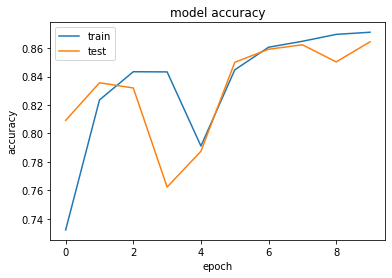

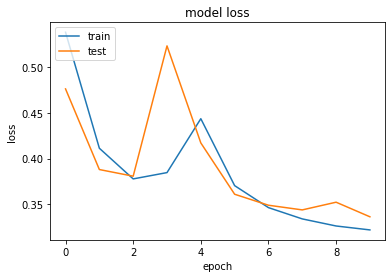

In [ ]:
y_pred = (Pretrain_ftmodelABiLSTM.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelABiLSTM)

#####Pretrain ft GRU

In [ ]:
emb_dim = ft_embedding_matrix.shape[1]
Pretrain_ft_gru_model = Sequential()
Pretrain_ft_gru_model.add(Embedding(vocab_size, emb_dim, trainable = False, weights=[ft_embedding_matrix]))
Pretrain_ft_gru_model.add(GRU(128, return_sequences=False))
Pretrain_ft_gru_model.add(Dropout(0.5))
Pretrain_ft_gru_model.add(Dense(1, activation = 'sigmoid'))
Pretrain_ft_gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(Pretrain_ft_gru_model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 300)         2324400   
                                                                 
 gru_1 (GRU)                 (None, 128)               165120    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,489,649
Trainable params: 165,249
Non-trainable params: 2,324,400
_________________________________________________________________
None


In [ ]:
history_Pretrain_ft_gru_model = Pretrain_ft_gru_model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTest_Pretrain_ft_gru_model= Pretrain_ft_gru_model.evaluate(x_test, y_test, verbose=1)



Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
119/120 [============================>.] - ETA: 0s - loss: 0.6014 - acc: 0.7171WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc0f8348a70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy : 
0.8398494668618022
150/150 [==============================] - 1s 4ms/step - loss: 0.4036 - acc: 0.8398
[0.403626024723053, 0.8398494720458984]
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1325
           1       0.87      0.91      0.89      3458

    accuracy                           0.84      4783
   ma

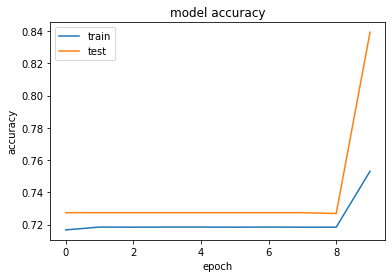

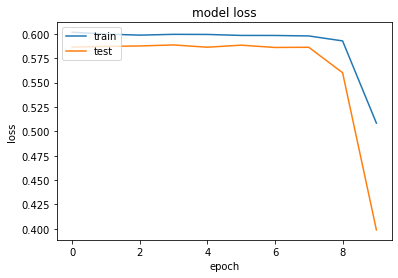

In [ ]:
y_pred = (Pretrain_ft_gru_model.predict(x_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ft_gru_model.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(history_Pretrain_ft_gru_model)

##BERT

In [ ]:
encoded_dict = {'neg':0,'pos':1}
got['cat'] = got.Sentiments.map(encoded_dict)
got['lemmatized_train'] = got.lemmatized.apply(lambda x: ' '.join(x))

xm = got['lemmatized_train'].tolist()
ym = to_categorical(got['cat'])


In [ ]:
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym)


In [ ]:
btokenizer = AutoTokenizer.from_pretrained ('bert-base-cased')

In [ ]:
xm_train = btokenizer(xm_train,add_special_tokens=True,max_length=100,
                      truncation=True,padding=True, return_tensors='tf',
                      return_token_type_ids = False,return_attention_mask = True,verbose = True)
xm_test = btokenizer(xm_test,add_special_tokens=True,max_length=100,
                      truncation=True,padding=True, return_tensors='tf',
                      return_token_type_ids = False,return_attention_mask = True,verbose = True)

In [ ]:
input_ids = xm_train['input_ids']
attention_mask = xm_train['attention_mask']

In [ ]:
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(2,activation = 'sigmoid')(out)
bert_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
bert_model.layers[2].trainable = True

optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),

bert_model.compile(optimizer = optimizer,loss = loss, metrics = metric)
bert_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [ ]:
historybert_model = bert_model.fit(x ={'input_ids':xm_train['input_ids'],'attention_mask':
                                       xm_train['attention_mask']} ,y = ym_train,
                                   validation_data = ({'input_ids':xm_test['input_ids'],'attention_mask':
                                                       xm_test['attention_mask']}, ym_test),epochs=1,batch_size=36)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
499/499 [==============================] - ETA: 0s - loss: 0.3293 - balanced_accuracy: 0.8654WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fbfa1d31f80> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [ ]:
scoreTestbert_model = bert_model .evaluate(xm_test, ym_test, verbose=1)


In [ ]:
ym_pred = (bert_model.predict(xm_test) >= 0.5).astype(int)
print("Accuracy : ")
print(accuracy_score(ym_test, ym_pred))
print(bert_model.evaluate(xm_test, ym_test))
print(classification_report(ym_test, ym_pred))
show_performance_plot(bert_model)

##Report

Game Of Thrones Script is considered from Kaggle to perform few embedding methods and modelling to compare their performance.

PreProcess & EDA : The Script is Preprocessed and EDA is performed to make the data ready for further analysis. Along with this, further EDA was on the book to understand the script ans characters.

Sentiment Analysis : A sentiment for each dialogue is identified using SentimentIntensityAnalyzer from vaderSentiment. The data is again split into training dataset using lemmatized_train and Sentiments identified from sentiment intensity analyzer
Later Bag of Words using Countvectorizer is built to get the words and their frequency

Embedding Modelling: Before working on any model the dataset is tokenized and padded into x_train , x_test , y_train, y_test

**Model Performance** : The performance evluation is done basis 
- Precision 
- recall 
- F1-score 
- support
- Performance Plot

---
**Model Performance When Trained from scratch**

---

Model 1: LSTM model built from scratch has an accuracy of **85.82%**

Accuracy : 
0.8582479615304203
150/150 [==============================] - 1s 6ms/step - loss: 0.6006 
              
              
              precision | recall | f1-score  |  support
              --- | ---

           0       0.77      0.70      0.73      1325
           1       0.89      0.92      0.90      3458

    accuracy                           0.86      4783
   macro avg       0.83      0.81      0.82      4783
  
weighted avg       0.86      0.86      0.86      4783

---

Model 2: BiLSTM model built from scratch has an accuracy of **85.87%**

Accuracy : 
0.8586661091365252
150/150 [==============================] - 1s 7ms/step - loss: 0.5454 - acc: 0.8587

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1325
           1       0.89      0.92      0.90      3458

    accuracy                           0.86      4783

   macro avg       0.83     0.81       0.82      4783

weighted avg       0.86      0.86      0.86      4783

---

Model 3: BiLSTM model with Attention Layer built from scratch has an accuracy of **86.01%**

Accuracy : 
0.8601296257578925
150/150 [==============================] - 1s 7ms/step - loss: 0.4144 - acc: 0.8601

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      1325
           1       0.89      0.92      0.90      3458

    accuracy                           0.86      4783

   macro avg       0.83      0.81      0.82      4783

weighted avg       0.86      0.86      0.86      4783

---

Model 4: LSTM using Word2Vec build from scratch has an accuracy of **85.07%**

Accuracy : 
0.8507213046205311
150/150 [==============================] - 1s 5ms/step - loss: 0.7520 - acc: 0.8507

              precision    recall  f1-score   support

           0       0.77      0.65      0.71      1325
           1       0.87      0.93      0.90      3458

    accuracy                           0.85      4783

   macro avg       0.82      0.79      0.80      4783

weighted avg       0.85      0.85      0.85      4783

---
Naives Bayes : this Classifier has an accuracy of **84.90%**

Model ROC-AUC score for training sample: 0.930
Model ROC-AUC score for test sample: 0.845
Train Accuracy ::  0.9052996355380295
Test Accuracy ::  0.8490381934764427

               precision    recall  f1-score   support

           0       0.61      0.80      0.69      1526
           1       0.94      0.86      0.90      5648

    accuracy                           0.85      7174

   macro avg       0.78      0.83      0.80      7174

weighted avg       0.87      0.85      0.86      7174

---

**PreTrained Glove Model**

---

Model 5: Pretrained Glove Model using LSTM has an accuracy of **86.85%**

Accuracy : 
0.8684925778799917
150/150 [==============================] - 1s 6ms/step - loss: 0.3573 - acc: 0.8685

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1325
           1       0.90      0.92      0.91      3458

    accuracy                           0.87      4783

   macro avg       0.84      0.82      0.83      4783

weighted avg       0.87      0.87      0.87      4783

---

Model 6: Pretrained Glove Model using BiLSTM has an accuracy of **85.72%**

Accuracy : 
0.8572025925151578
150/150 [==============================] - 2s 11ms/step - loss: 0.3890 - acc: 0.8572

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1325
           1       0.89      0.91      0.90      3458

    accuracy                           0.86      4783

   macro avg       0.83      0.81      0.82      4783

weighted avg       0.85      0.86      0.86      4783

---

Model 7: Pretrained Glove Model using BiLSTM with Attention Layer has an accuracy of **85.32%**

Accuracy : 
0.8532301902571607
150/150 [==============================] - 1s 7ms/step - loss: 0.3619 - acc: 0.8532

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      1325
           1       0.88      0.92      0.90      3458

    accuracy                           0.85      4783

   macro avg       0.82      0.80      0.81      4783

weighted avg       0.85      0.85      0.85      4783

---

Model 8: Pretrained Glove using GRU Model has an accuracy of **72.30%**

Accuracy : 
0.7229772109554673
150/150 [==============================] - 1s 4ms/step - loss: 0.5903 - acc: 0.7230

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1325
           1       0.72      1.00      0.84      3458

    accuracy                           0.72      4783

   macro avg       0.36      0.50      0.42      4783

weighted avg       0.52      0.72      0.61      4783

---

Pretrained Word2Vec

---


Model 9: Pretrained Word2vec using LSTM has an accuracy of **84.82%**

Accuracy : 
0.8482124189839013
150/150 [==============================] - 1s 7ms/step - loss: 0.3879 - acc: 0.8482

              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1325
           1       0.87      0.93      0.90      3458

    accuracy                           0.85      4783

   macro avg       0.82      0.78      0.80      4783

weighted avg       0.84      0.85      0.84      4783

---

Model 10: Pretrained Word2vec using BiLSTM has an accuracy of **85.45%**

Accuracy : 
0.8544846330754756
150/150 [==============================] - 2s 10ms/step - loss: 0.4513 - acc: 0.8545

              precision    recall  f1-score   support

           0       0.73      0.74      0.74      1325
           1       0.90      0.90      0.90      3458

    accuracy                           0.85      4783

   macro avg       0.82      0.82      0.82      4783

weighted avg       0.85      0.85      0.85      4783

---

Model 11: Pretrained Word2vec using BiLSTM with Attention Layer has an accuracy of **86.64%**

Accuracy : 
0.8664018398494668
150/150 [==============================] - 1s 7ms/step - loss: 0.3418 - acc: 0.8664

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      1325
           1       0.90      0.92      0.91      3458

    accuracy                           0.87      4783

   macro avg       0.84      0.83      0.83      4783

weighted avg       0.86      0.87      0.87      4783

---

Model 12: Pretrained Word2vec using GRU has an accuracy of **86.64%**

---

Pretrained FastText

---

Model 13: Pretrained FastText using LSTM has an accuracy of **87.02%**

Accuracy : 
0.8701651683044115
150/150 [==============================] - 1s 8ms/step - loss: 0.3278 - acc: 0.8702

              precision    recall  f1-score   support

           0       0.84      0.66      0.74      1325
           1       0.88      0.95      0.91      3458

    accuracy                           0.87      4783

   macro avg       0.86      0.80      0.83      4783

weighted avg       0.87      0.87      0.86      4783

---
Model 14: Pretrained FastText using BiLSTM has an accuracy of **87.10%**

Accuracy : 
0.8710014635166213
150/150 [==============================] - 1s 10ms/step - loss: 0.3498 - acc: 0.8710

              precision    recall  f1-score   support

           0       0.80      0.72      0.75      1325
           1       0.90      0.93      0.91      3458

    accuracy                           0.87      4783

   macro avg       0.85      0.82      0.83      4783

weighted avg       0.87      0.87      0.87      4783

---
Model 15: Pretrained FastText using BiLSTM with Attention Layer has an accuracy of **87.52%**

Accuracy : 
0.8751829395776709
150/150 [==============================] - 1s 10ms/step - loss: 0.3254 - acc: 0.8752

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1325
           1       0.91      0.92      0.91      3458

    accuracy                           0.88      4783

   macro avg       0.85      0.84      0.84      4783

weighted avg       0.87      0.88      0.87      4783

---

Model 15: Pretrained FastText using GRU  has an accuracy of **86.43%**

Accuracy : 
0.8643111018189421
150/150 [==============================] - 1s 7ms/step - loss: 0.3484 - acc: 0.8643

              precision    recall  f1-score   support

           0       0.80      0.68      0.74      1325
           1       0.89      0.93      0.91      3458

    accuracy                           0.86      4783

   macro avg       0.84      0.81      0.82      4783

weighted avg       0.86      0.86      0.86      4783

---
BERT

---

499/499 [==============================] - 290s 526ms/step - loss: 0.3293 - balanced_accuracy: 0.8654 - val_loss: 0.2722 - val_balanced_accuracy: 0.8968

              precision    recall  f1-score   support

           0       0.82      0.68      0.83      310
           1       0.48      0.93      0.47      227
           2       0.95      0.94      0.95      1513

    accuracy                           0.88      2050

   macro avg       0.75      0.81      0.75      2050

weighted avg       0.88      0.88      0.88      2050

---

**Disclosure : The Model performance varies from data set.**

Multiple Factors needs to be considered while choosing the accurate method. 

All the model did take similar amount of time however while considering Pretrained Word2Vec models , The system faced multiple crashes considered the size of the data.

With respect to Accuracy BERT has outperformed the remaining.


